<a href="https://colab.research.google.com/github/Aa-transparent/Colab_copy/blob/main/NeuroBOLT_inference_demo_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NeuroBOLT Inference Demo



### **Introduction**
**Notes**: This notebook shows a demo of translating EEG signals into fMRI ROI signal (Thalamus as an example here), using the pretrained `NeuroBOLT` model.

`NeuroBOLT` supports:
- Any configuration of EEG electrodes as input when training from scratch.
- Any subset of the existing EEG electrode configuration from either new data or VU dataset if using pretrained version of the model.

<!-- **Background**:

![background](https://raw.githubusercontent.com/brainhack-vandy/how-to-start-latest-ml-approaches/refs/heads/main/assets/bg.png) -->






***
### **Resources**
- [**Paper**](https://arxiv.org/abs/2410.05341):
*Li, Yamin, et al. "NeuroBOLT: Resting-state EEG-to-fMRI Synthesis with Multi-dimensional Feature Mapping." Advances in Neural Information Processing Systems (2024)*

- [**Project page**](https://soupeeli.github.io/NeuroBOLT/)
| [**Codebase**](https://github.com/soupeeli/NeuroBOLT) |
[**Dataset**](https://huggingface.co/datasets/NeurdyLab/NeuroBOLT)
| [**Checkpoints**](https://huggingface.co/ssssssup/NeuroBOLT/tree/main)
| [**Poster**](https://neurips.cc/media/PosterPDFs/NeurIPS%202024/93044.png?t=1733617950.057914)

***
### **Pipelines**

0. Setup
1. Data Preparation
    * Getting the data
    * Preprocess and segment EEG according to the fMRI collection event
    * Extract picked fMRI ROI time course with some preprocessing
    * Convert into tensor
2. Configuration and Initialization
    * Initialize the model architecture and run data extractor.
    * Load the checkpoint corresponding to the chosen fMRI ROI.
3. Inference
    * Run the model on the prepared data to perform inference.

***

### **0. Setup**



#### 0.1 Download data and prepare environment

In [ ]:
!git clone https://github.com/soupeeli/NeuroBOLT.git
%cd NeuroBOLT

Cloning into 'NeuroBOLT'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 183 (delta 35), reused 40 (delta 13), pack-reused 91 (from 1)
Receiving objects: 100% (183/183), 75.12 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/NeuroBOLT


In [ ]:
!pip install torch torchvision linear-attention-transformer==0.19.1 timm numpy pandas matplotlib einops scipy mne==1.4.2 scikit-learn jupyter h5py tensorboardX huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 137.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.1 MB/s eta 0:00:00


In [ ]:
import os
import shutil
from huggingface_hub import hf_hub_download

repo_id = "NeurdyLab/NeuroBOLT"   # Hugging Face dataset repository ID
scan_name = "sub16-scan01"

# Define local target folders
base_data_dir = "data"
eeg_dir = os.path.join(base_data_dir, "EEG")
fmri_dir = os.path.join(base_data_dir, "fMRI_difumo")

# Create folders if they don't exist
os.makedirs(eeg_dir, exist_ok=True)
os.makedirs(fmri_dir, exist_ok=True)

# Files to download
files_to_download = [
    (f"EEG_set/{scan_name}_eeg.set", eeg_dir),
    (f"EEG_set/{scan_name}_eeg.fdt", eeg_dir),
    (f"fMRI_difumo64/{scan_name}_difumo64_roi.pkl", fmri_dir),
]

local_files = []
for file, target_dir in files_to_download:
    # Download from Hugging Face dataset
    cached_file = hf_hub_download(
        repo_id=repo_id,
        repo_type="dataset",   # IMPORTANT: it's a dataset
        filename=file
    )

    # Copy into your project structure
    target_path = os.path.join(target_dir, os.path.basename(file))
    shutil.copy(cached_file, target_path)

    local_files.append(target_path)
    print(f"Downloaded {file} → {target_path}")

print("All files saved to:", local_files)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


EEG_set/sub16-scan01_eeg.set:   0%|          | 0.00/4.89M [00:00<?, ?B/s]

Downloaded EEG_set/sub16-scan01_eeg.set → data/EEG/sub16-scan01_eeg.set


EEG_set/sub16-scan01_eeg.fdt:   0%|          | 0.00/43.5M [00:00<?, ?B/s]

Downloaded EEG_set/sub16-scan01_eeg.fdt → data/EEG/sub16-scan01_eeg.fdt


fMRI_difumo64/sub16-scan01_difumo64_roi.(…):   0%|          | 0.00/154k [00:00<?, ?B/s]

Downloaded fMRI_difumo64/sub16-scan01_difumo64_roi.pkl → data/fMRI_difumo/sub16-scan01_difumo64_roi.pkl
All files saved to: ['data/EEG/sub16-scan01_eeg.set', 'data/EEG/sub16-scan01_eeg.fdt', 'data/fMRI_difumo/sub16-scan01_difumo64_roi.pkl']


3) Import the required libraries by running code below:

In [ ]:
import torch
import numpy as np
import utils
import models.model
from timm.models import create_model

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from dataset_maker import get_datasets, preproc
from einops import rearrange
from scipy.signal import butter, filtfilt
from sklearn.metrics import mean_squared_error
import math
import pickle
import matplotlib.ticker as ticker
import re
import mne


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


#### 0.2 Test model with dummy input

In [ ]:
# Initializing the model
model = create_model(
    'neurobolt_default',
    EEG_channel=26,
    pretrained=False,
    num_roi=1,
    drop_rate=0.0,
    drop_path_rate=0.1,
    attn_drop_rate=0.0,
    drop_block_rate=None,
    use_mean_pooling=True,
    init_scale=0.001,
    use_rel_pos_bias=False,
    use_abs_pos_emb=True,
    init_values=0.1,
    qkv_bias=False,
)

# Sample data (batch_size, n_channels, n_windows, windowsize)
x = torch.randn(8, 26, 16, 200)
input_chans_lbm = np.arange(26+1)  # Generating dummy channel indices with cls token position
input_chans_spect = np.arange(26)
with torch.no_grad():
    out = model(x, input_chans=input_chans_lbm, input_chans_spect=input_chans_spect)
    print(out.shape)

/usr/local/lib/python3.12/dist-packages/torch/functional.py:730: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(  # type: ignore[attr-defined]


torch.Size([8, 1])


<!-- ![Demo](https://raw.githubusercontent.com/brainhack-vandy/how-to-start-latest-ml-approaches/refs/heads/main/assets/teaser-gif.gif) -->

### **1. Data Preparation**

#### Provided data format:
<!-- ![multichan](https://raw.githubusercontent.com/brainhack-vandy/how-to-start-latest-ml-approaches/refs/heads/main/assets/multi-chan.png) -->
- **EEG**: EEGLAB format (.set)
- **fMRI**: ROI time series extracted using DiFuMo, stored as a Pandas DataFrame with ROI labels (saved in a .pkl file), *see visualization below*.

<!-- **EEG** (channel x timepoints)

![EEG vis from EEGLAB](https://raw.githubusercontent.com/brainhack-vandy/how-to-start-latest-ml-approaches/refs/heads/main/assets/eeg_set_vis_eg.jpg) -->

<!-- **fMRI ROI signals** (ROI x timepoints) -->

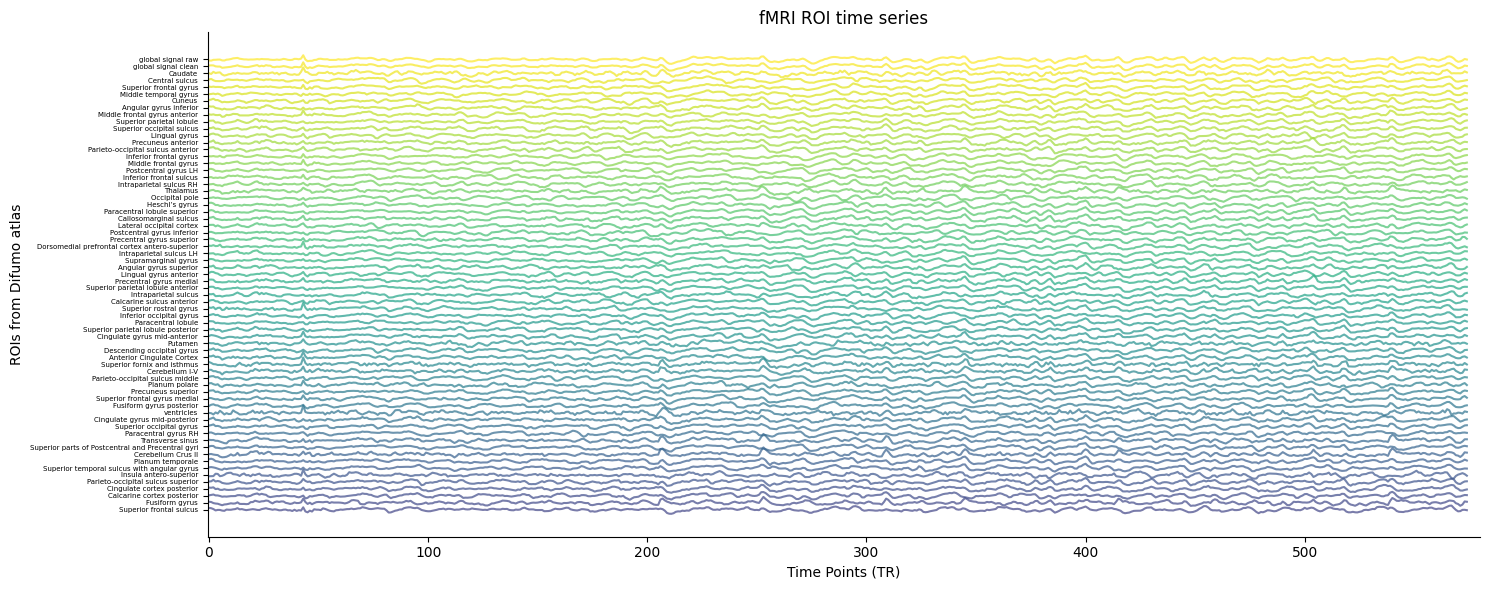

In [ ]:
import matplotlib.cm as cm
fMRI_difumo_path = f'./data/fMRI_difumo/{scan_name}_difumo64_roi.pkl'
df_fmri = pd.read_pickle(fMRI_difumo_path)

# Transpose the DataFrame so that rows represent ROIs and columns represent time
df_transposed = df_fmri.T

# Plot each ROI as a separate time series
plt.figure(figsize=(15, 6))
row_gap=5

# Generate a colormap (light to dark)
colors = cm.viridis(np.linspace(0.2, 1, len(df_transposed.index)))

for i, (roi_label, row) in enumerate(df_transposed.iterrows()):
    plt.plot(df_transposed.columns, row + i*row_gap , label=f"{roi_label}", color=colors[i], alpha=0.7)

# Add labels, legend, and title
plt.yticks(range(0, len(df_transposed.index) * row_gap, row_gap), df_transposed.index, fontsize=5)

plt.xlabel("Time Points (TR)")
plt.xlim([-0.5, 580])
plt.ylabel("ROIs from Difumo atlas")
plt.title("fMRI ROI time series")
plt.tight_layout()

# Remove the border around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show()

First, we will use the function provided below to process and organize the data, preparing it for input into the model. The function will do the following things:
1. **Load Data:** Reads EEG data and fMRI ROI time series from the input files.
2. **Extract ROI Signal:** Retrieves the signal for the selected ROI (Thalamus in this example) from 66 available ROIs.
3. **Preprocess fMRI Data:** Applies preprocessing steps, including low-pass filtering and normalization.
4. **Segment EEG Data:** Extracts 16-second EEG segments preceding each fMRI scan collection time, based on event annotations in the EEG dataset.
5. **Data Splitting:** Splits the processed data into training, validation, and test sets, organizing it for model input.

In [ ]:
def prepare_VU_onesub_dataloader(labels_roi, sub, scan, dataset='VU', mode='fullscan-inference'):
    # set random seed
    seed = 12345
    np.random.seed(seed)
    root = './data/'
    TR = 2.1

    original_fps = 250
    new_fps = 200
    tmin = -16
    tmax = 0
    atlas = 'Difumo'
    selected_event = None

    event_sync_name = "R149"
    eeg_raw, fmri, labels_roi_full = get_datasets.download_vu_dataset(sub, scan, root,
                                                                      output_eegmneraw=True)
    fmri_np = fmri.to_numpy().T


    # Pick ROI
    df = pd.DataFrame(data=fmri_np.T, columns=labels_roi_full)
    df_filter = df[labels_roi]
    fmri_np = df_filter.to_numpy().T
    if len(fmri_np.shape) < 2:
        fmri_np = fmri_np[np.newaxis, ...]

    # optional: add low-pass filtering, filter below 0.15Hz
    fs = 1 / TR
    nyquist = 0.5 * fs
    low = 0.15 / nyquist  # Low cutoff frequency (as a fraction of Nyquist frequency)
    b, a = butter(N=5, Wn=low, btype='low', analog=False)  # Using a 5th order filter
    fmri_np = filtfilt(b, a, fmri_np)

    # Normalize fMRI time series
    fmri_norm, _ = preproc.normalize_data(fmri_np)

    # epoching data, and divide them into train, val and test
    data_epoch, eeg_info = preproc.epoching_seq2one(eeg_raw, fmri_norm,
                                                    tmin, tmax, event_sync_name, ifnorm=1,
                                                    crop=3200)

    traincrop = int(0.8 * len(data_epoch["eeg"]))
    valcrop = int(0.1 * len(data_epoch["eeg"])) + traincrop

    if abs(tmin) <= 20:  # consider the auto-correlation of fMRI
        t_overlap = 20
    else:
        t_overlap = abs(tmin)

    N_overlap = math.ceil(t_overlap / TR)
    traincrop = traincrop + N_overlap
    valcrop = valcrop + N_overlap

    if mode == 'fullscan-inference':
        test_files = (data_epoch["eeg"], data_epoch["fmri"])
        print(len(test_files[0]))
        return test_files
    elif mode in ['intrascan-inference','intrascan-training']:
        train_files = (data_epoch["eeg"][:traincrop], data_epoch["fmri"][:traincrop])
        val_files = (data_epoch["eeg"][traincrop:valcrop], data_epoch["fmri"][traincrop:valcrop])
        test_files = (data_epoch["eeg"][valcrop:], data_epoch["fmri"][valcrop:])
        print(len(train_files[0]), len(val_files[0]), len(test_files[0]))
        return train_files, test_files, val_files


### **2. Configuration and Initialization**

To run the function above, we need to define the following configurations first:
- **`testlist`**: A list of scan names to be used for testing.
- **`ROI_name`**: The label of the selected Region of Interest (ROI) in the DiFuMo atlas.
- **`ROI_ckp_name`**: The filename of the checkpoint corresponding to the selected ROI.
- **`dataset`**: The name of the dataset to be used.
- **`mode`**: Specifies the inference mode:
    - `fullscan-inference`: Perform inference on an unseen scan (full-scan reconstruction).
    - `intrascan-inference`: Train and test on the same scan (within-scan evaluation).
- **`ch_names_input`**: The list of input channel names, which can be any subset of the full set of channels used in the model:
['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'FPZ', 'FZ', 'CZ', 'PZ', 'POZ', 'OZ', 'FT9', 'FT10', 'TP9', 'TP10']

In [ ]:
CH_NAMES_FULL = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8',
                 'P7', 'P8', 'FPZ', 'FZ', 'CZ', 'PZ', 'POZ', 'OZ', 'FT9', 'FT10', 'TP9', 'TP10']  # 26 channels (full channel set used in the model)
# ====== Configs ======
testlist = ['sub16-scan01']
ROI_name = 'Thalamus'
ROI_ckp_namne = 'Thalamus'
dataset = 'VU'
mode='fullscan-inference'
ch_names_input = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8',
                 'P7', 'P8', 'FPZ', 'FZ', 'CZ', 'PZ', 'POZ', 'OZ', 'FT9', 'FT10', 'TP9', 'TP10'] # order need to match the original order in ch_names_full
# ======================

test_data_list = []
for sss in testlist:
    sub, scan = None, None
    sub, scan = re.findall(r'\d+', sss)
    sub, scan = int(sub), int(scan)

    if mode =='intrascan-inference':
        _,test_data,_ = prepare_VU_onesub_dataloader(ROI_name, sub, scan, dataset, mode)
    else:
        test_data = prepare_VU_onesub_dataloader(ROI_name, sub, scan, dataset, mode)
    test_data_list.append(test_data)

Reading /content/NeuroBOLT/data/EEG/sub16-scan01_eeg.fdt


/content/NeuroBOLT/dataset_maker/get_datasets.py:24: RuntimeWarning: Estimated head radius (0.1 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/content/NeuroBOLT/dataset_maker/get_datasets.py:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)
/content/NeuroBOLT/dataset_maker/get_datasets.py:24: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(eeg_path_set_file)


Used Annotations descriptions: [np.str_('R'), np.str_('R 21'), np.str_('R149'), np.str_('boundary')]
Not setting metadata
575 matching events found
Setting baseline interval to [-16.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 575 events and 3201 original time points ...
8 bad epochs dropped
567


Then we’ll initialize the model and load its pretrained weights. The model was trained using raw EEG signal to synthesis the corresponding simultanous fMRI signal within `Thalamus`, which is located deep within the brain.

In [ ]:
# Initializing the model
model = create_model(
    'neurobolt_default',
    pretrained=False,
    num_roi=1,
    drop_rate=0.0,
    drop_path_rate=0.1,
    attn_drop_rate=0.0,
    drop_block_rate=None,
    use_mean_pooling=True,
    init_scale=0.001,
    use_rel_pos_bias=False,
    use_abs_pos_emb=True,
    init_values=0.1,
    qkv_bias=False,
)

# Download checkpoint from Hugging Face
repo_id_checkpoint = "ssssssup/NeuroBOLT"
filename_checkpoint = f"checkpoints/{ROI_ckp_namne}.pth"

checkpoint_path = hf_hub_download(
    repo_id=repo_id_checkpoint,
    filename=filename_checkpoint,
    repo_type="model"
)
print(checkpoint_path)

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'),weights_only=False)
model.load_state_dict(checkpoint['model'])

checkpoints/Thalamus.pth:   0%|          | 0.00/96.0M [00:00<?, ?B/s]

/root/.cache/huggingface/hub/models--ssssssup--NeuroBOLT/snapshots/c62e07978e1b9d7d9faabdfad385b91f074e9ce5/checkpoints/Thalamus.pth


<All keys matched successfully>


Here, `CH_NAMES_FULL` is the channel set that was used to train the model. `ch_names_input` is the channel set here in this demo you would like to use to make the prediction, which can be any **subset** of full channels: `CH_NAMES_FULL`.

<!-- <img style="float: left;" src="https://raw.githubusercontent.com/brainhack-vandy/how-to-start-latest-ml-approaches/refs/heads/main/assets/chans.png" width="30%"> -->

In [ ]:
# CH_NAMES_FULL = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8',
#                  'P7', 'P8', 'FPZ', 'FZ', 'CZ', 'PZ', 'POZ', 'OZ', 'FT9', 'FT10', 'TP9', 'TP10']  # 26 channels
# ch_names_input = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8',
#                  'P7', 'P8', 'FPZ', 'FZ', 'CZ', 'PZ', 'POZ', 'OZ', 'FT9', 'FT10', 'TP9', 'TP10']
# ch_names = ch_names_full  # choosing the full channel list in the model

# get the channel index for two modules in NeuroBOLT model
input_chans = utils.get_input_chans(ch_names_input) # this is for the channel indexing in LaBraM
used_chan_ind = [CH_NAMES_FULL.index(channel) for channel in ch_names_input] # todo This is for the channel indexing in MS-spectral module



### **3. Run inference**
In this section, we will send the data we prepared into the model and visualize the results. We use `temporal correlation` between prediction and ground truth as the primary metric to evaluate the model performance.

#### 3.1 Full-channel input
First, we are using all the channels (electrodes) in EEG data.

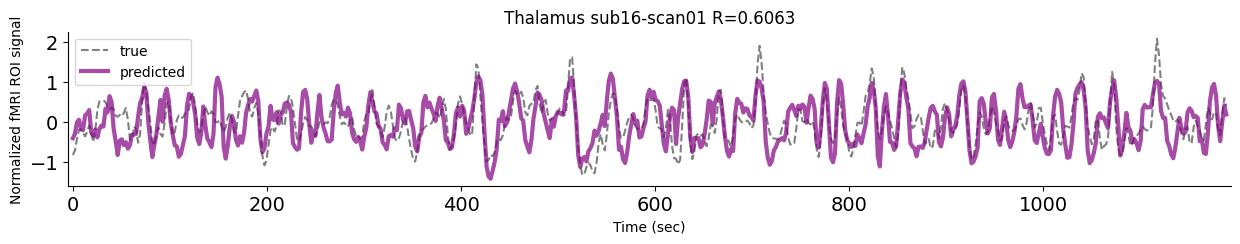

In [ ]:
corr_list = []
mse_list = []
TR = 2.1
with torch.no_grad():
    model = model.to(device)
    model.eval()
    for tt in range(len(test_data_list)):
        test_data = test_data_list[tt]
        X_test = np.array(test_data[0])
        y_test = np.array(test_data[1])
        y_hats = []
        y_test_array = []

        x_batch = torch.from_numpy(X_test).float().to(device)
        EEG = x_batch[:, used_chan_ind, :] / 100
        if len(EEG.shape) < 3:
            EEG = EEG.unsqueeze(1)

        EEG = rearrange(EEG, 'B N (A T) -> B N A T', T=200) #token size(window length)=200

        y_hat = model(EEG, input_chans=input_chans, input_chans_spect=used_chan_ind)
        y_hat = y_hat.to('cpu').detach().numpy().squeeze()
        y_hat, _ = preproc.normalize_data(y_hat)


        corrval = np.corrcoef(y_hat.squeeze(), y_test.squeeze())[0, 1]
        mse = mean_squared_error(y_hat.squeeze(), y_test.squeeze())
        corr_list.append(corrval)
        mse_list.append(mse)


        # ---- Visualization ------
        if mode =='intrascan-inference':
            plt.figure(figsize=(10, 2))
        else:
            plt.figure(figsize=(15, 2))

        xdata = np.arange(len(y_test)) * TR # TR = 2.1

        plt.plot(xdata, y_test.squeeze(), label='true', color='grey', linestyle='dashed')
        plt.plot(xdata, y_hat.squeeze(), label='predicted', color='purple', linewidth=3, alpha=0.7)

        plt.legend()

        plt.xlim(-5, int(xdata[-1]) + 5)
        plt.xticks(fontsize=14)
        plt.xlabel('Time (sec)')

        plt.yticks(fontsize=14)
        # plt.ylim(-1.5,1.5)
        plt.ylabel('Normalized fMRI ROI signal')
        plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))
        ax = plt.gca()

        # Hide the top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # # Optionally, you can move the bottom and left spines to the zero position
        # ax.spines['left'].set_position('zero')
        # ax.spines['bottom'].set_position('zero')

        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        plt.title(f"{ROI_name} {testlist[tt]} R={corrval:.4f}")


#### 3.2 Partial-channel input
As mentioned in the introductioin, `NeuroBOLT` also supports any subset of channels as input as shown below:


<!-- <img src="https://raw.githubusercontent.com/brainhack-vandy/how-to-start-latest-ml-approaches/refs/heads/main/assets/part-chan.png" width="80%"> -->

**Support channels**
Select any subset of channels from the list below. If you are running inference on your own data, ensure that the channel order in your data matches this order:
- ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8',
                 'P7', 'P8', 'FPZ', 'FZ', 'CZ', 'PZ', 'POZ', 'OZ', 'FT9', 'FT10', 'TP9', 'TP10']

In [ ]:
ch_names_input = ['FP2', 'F4', 'C4', 'O2', 'T8', 'P7', 'CZ', 'POZ'] # order need to match the original order in ch_names_full

# get the channel index for two modules in NeuroBOLT model
input_chans = utils.get_input_chans(ch_names_input) # this is for the channel indexing in LaBraM
used_chan_ind = [CH_NAMES_FULL.index(channel) for channel in ch_names_input] # This is for the channel indexing in MS-spectral module
# used_chan_ind.sort()

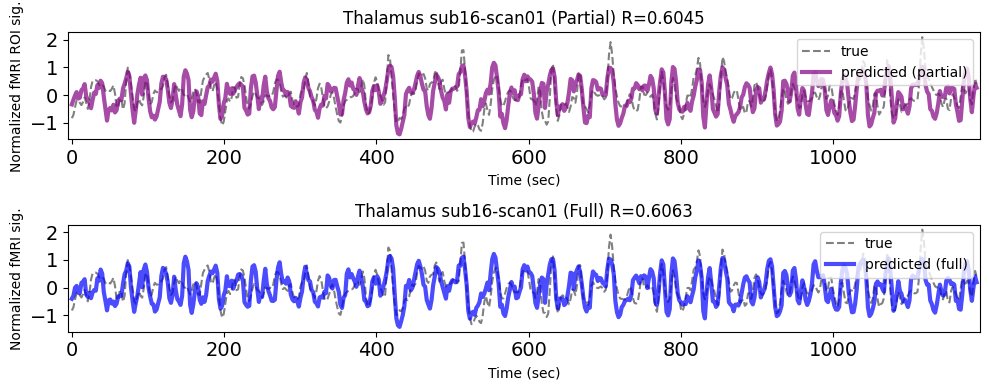

In [ ]:
corr_list = []
mse_list = []
TR = 2.1
with torch.no_grad():
    model = model.to(device)
    model.eval()
    for tt in range(len(test_data_list)):
        test_data = test_data_list[tt]
        X_test = np.array(test_data[0])
        y_test = np.array(test_data[1])
        y_hats = []
        y_test_array = []

        x_batch = torch.from_numpy(X_test).float().to(device)
        EEG = x_batch[:, used_chan_ind, :] / 100
        if len(EEG.shape) < 3:
            EEG = EEG.unsqueeze(1)

        EEG = rearrange(EEG, 'B N (A T) -> B N A T', T=200) #token size(window length)=200

        y_hat_partial = model(EEG, input_chans=input_chans, input_chans_spect=used_chan_ind)
        y_hat_partial = y_hat_partial.to('cpu').detach().numpy().squeeze()
        y_hat_partial, _ = preproc.normalize_data(y_hat_partial)


        corrval_partial = np.corrcoef(y_hat_partial.squeeze(), y_test.squeeze())[0, 1]
        mse_partial = mean_squared_error(y_hat_partial.squeeze(), y_test.squeeze())
        corr_list.append(corrval)
        mse_list.append(mse)


        # ---- Visualization ------
        plt.figure(figsize=(10, 4))


        xdata = np.arange(len(y_test)) * TR  # TR = 2.1

        # First subplot for y_hat_partial
        plt.subplot(2, 1, 1)
        plt.plot(xdata, y_test.squeeze(), label='true', color='grey', linestyle='dashed')
        plt.plot(xdata, y_hat_partial.squeeze(), label='predicted (partial)', color='purple', linewidth=3, alpha=0.7)
        plt.legend(loc='upper right')
        plt.xlim(-5, int(xdata[-1]) + 5)
        plt.xticks(fontsize=14)
        plt.xlabel('Time (sec)')
        plt.yticks(fontsize=14)
        plt.ylabel('Normalized fMRI ROI sig.')
        plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.title(f"{ROI_name} {testlist[tt]} (Partial) R={corrval_partial:.4f}")

        # Second subplot for y_hat
        plt.subplot(2, 1, 2)
        plt.plot(xdata, y_test.squeeze(), label='true', color='grey', linestyle='dashed')
        plt.plot(xdata, y_hat.squeeze(), label='predicted (full)', color='blue', linewidth=3, alpha=0.7)
        plt.legend(loc='upper right')
        plt.xlim(-5, int(xdata[-1]) + 5)
        plt.xticks(fontsize=14)
        plt.xlabel('Time (sec)')
        plt.yticks(fontsize=14)
        plt.ylabel('Normalized fMRI sig.')
        plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.title(f"{ROI_name} {testlist[tt]} (Full) R={corrval:.4f}")

        # Improve layout
        plt.tight_layout()
        plt.show()